In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.core import NeuralForecast
from neuralforecast.models import LSTM

from datetime import datetime, timedelta

In [2]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
from neuralforecast.losses.pytorch import MQLoss

In [4]:
NeuralForecast.save?

Signature:
NeuralForecast.save(
    self,
    path: str,
    model_index: Optional[List] = None,
    save_dataset: bool = True,
    overwrite: bool = False,
)
Docstring:
Save NeuralForecast core class.

`core.NeuralForecast`'s method to save current status of models, dataset, and configuration.
Note that by default the `models` are not saving training checkpoints to save disk memory,
to get them change the individual model `**trainer_kwargs` to include `enable_checkpointing=True`.

Parameters
----------
path : str
    Directory to save current status.
model_index : list, optional (default=None)
    List to specify which models from list of self.models to save.
save_dataset : bool (default=True)
    Whether to save dataset or not.
overwrite : bool (default=False)
    Whether to overwrite files or not.
File:      ~/.local/lib/python3.11/site-packages/neuralforecast/core.py
Type:      function

In [8]:
class FixedModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        
        self.nf = None
        
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
        
    
    def create_fixed_model(self, h, freq, model_name, level = []):
        #Creating AutoLSTM model and predicting with hyperparameter tuning by optuna backend. This is based upon the first training dataframe
        
        #Checking if model has already been loaded in and fit
        if not self.nf:
            if not level:
                self.nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna")], freq = freq)
                self.nf.fit(df = self.dfs[0])
            else:
                self.nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level))], freq = freq)
                self.nf.fit(df = self.dfs[0])
            
            self.nf.save(path=f'AutoLSTM/fixed_models/{model_name}/')

        for i in range(len(self.dfs)):
            df = self.dfs[i]
            y_hat = self.nf.predict(df = df)

            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

    
    def load_fixed_model(self, path):
        self.nf = NeuralForecast.load(path = path)
        
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Fixed Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
            
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
        
            
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [48]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [49]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [16]:
Processor = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [17]:
Processor.create_training_dfs(value_col = "value")

In [18]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", model_name = "test_model", level = [80, 95])

[I 2025-05-22 16:56:58,384] A new study created in memory with name: no-name-16429ae9-da54-4356-9b39-fa0e3ff416a9
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 41.2 K | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 16:57:09,414] Trial 0 finished with value: 21.401447296142578 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0030614667654459498, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 13, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 21.401447296142578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 16:57:17,306] Trial 1 finished with value: 43.894065856933594 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0004939247895768283, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 4, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 21.401447296142578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:57:21,126] Trial 2 finished with value: 77.65647888183594 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.0002877423364697511, 'max_steps': 500, 'batch_size': 16, 'random_seed': 2, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 21.401447296142578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:57:25,367] Trial 3 finished with value: 566.0895385742188 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.00024881892957134816, 'max_steps': 500, 'batch_size': 16, 'random_seed': 4, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 21.401447296142578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 16:57:36,248] Trial 4 finished with value: 20.563716888427734 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.005936252041240826, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 11, 'input_size': 256, 'inference_input_size': -4}. Best is trial 4 with value: 20.563716888427734.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:57:40,256] Trial 5 finished with value: 34.02164840698242 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.07726944887764096, 'max_steps': 500, 'batch_size': 32, 'random_seed': 18, 'input_size': 64, 'inference_input_size': -4}. Best is trial 4 with value: 20.563716888427734.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:57:45,667] Trial 6 finished with value: 37.923622131347656 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0012775754634827305, 'max_steps': 500, 'batch_size': 32, 'random_seed': 3, 'input_size': -4, 'inference_input_size': -4}. Best is trial 4 with value: 20.563716888427734.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 16:57:54,625] Trial 7 finished with value: 12.973150253295898 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.008325315465202042, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 18, 'input_size': 16, 'inference_input_size': -4}. Best is trial 7 with value: 12.973150253295898.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:58:05,725] Trial 8 finished with value: 487.1432189941406 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.07412531680453144, 'max_steps': 500, 'batch_size': 16, 'random_seed': 20, 'input_size': 256, 'inference_input_size': -4}. Best is trial 7 with value: 12.973150253295898.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 16:58:09,746] Trial 9 finished with value: 12.960429191589355 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.007025781935496022, 'max_steps': 500, 'batch_size': 32, 'random_seed': 8, 'input_size': -4, 'inference_input_size': -4}. Best is trial 9 with value: 12.960429191589355.
[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 31.0 K | train
4 | context_adapter | Linear        | 10.2 K | train
5 | mlp_decod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
len(Processor.forecasts)

5

/tmp/ipykernel_336753/640007668.py:69: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



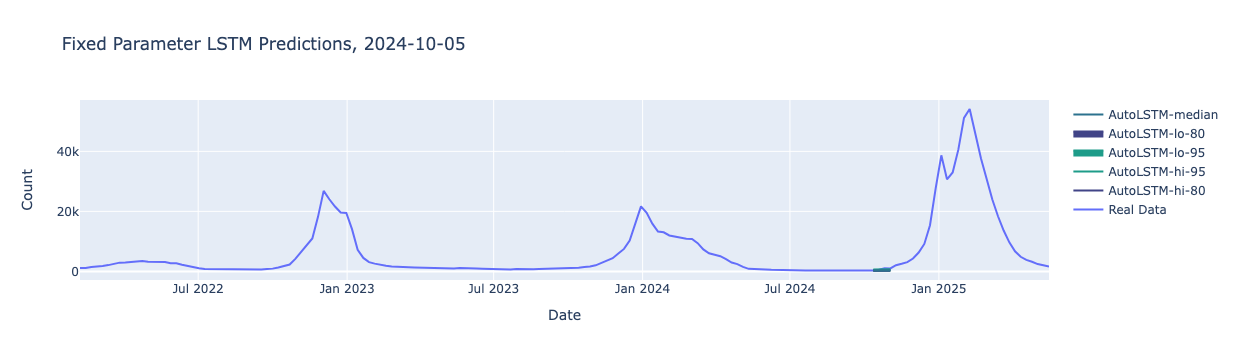

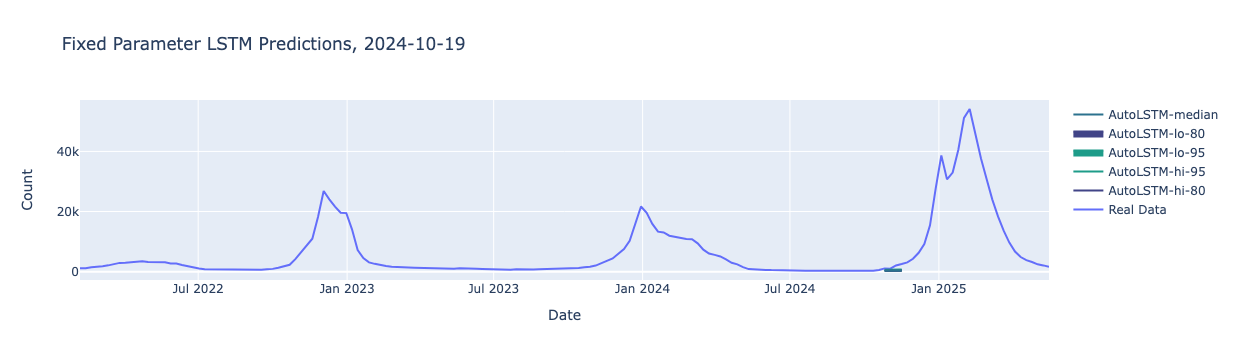

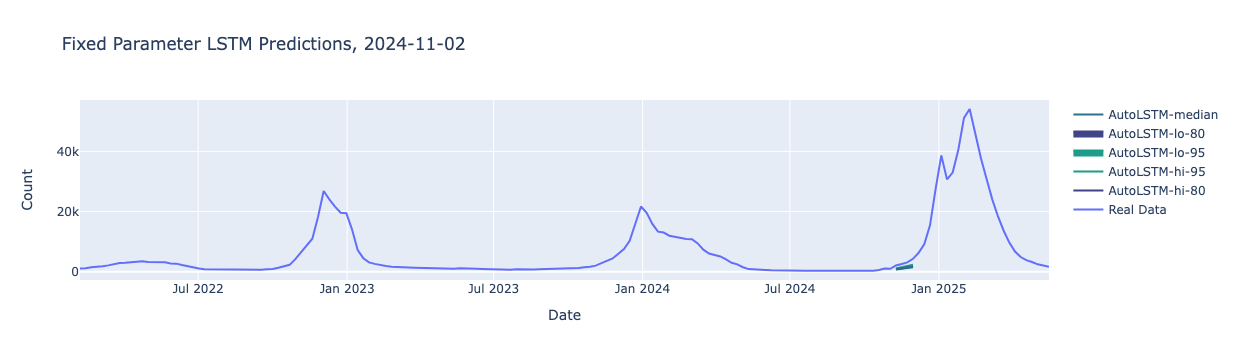

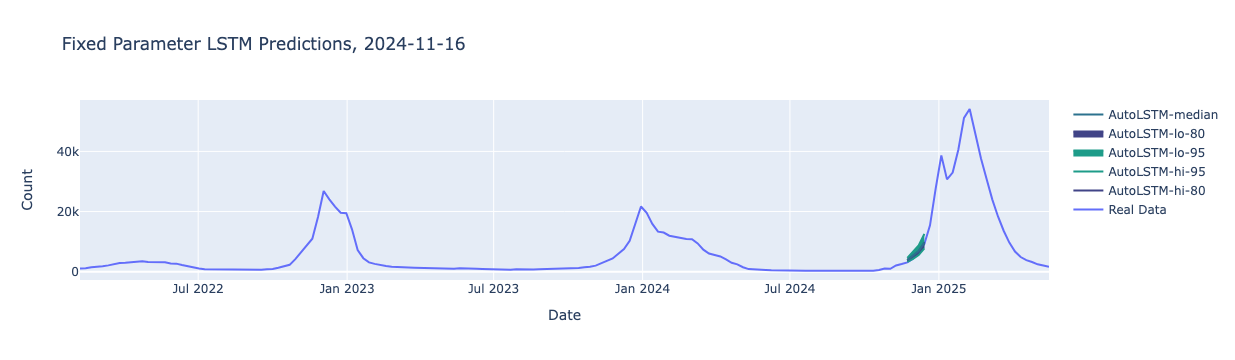

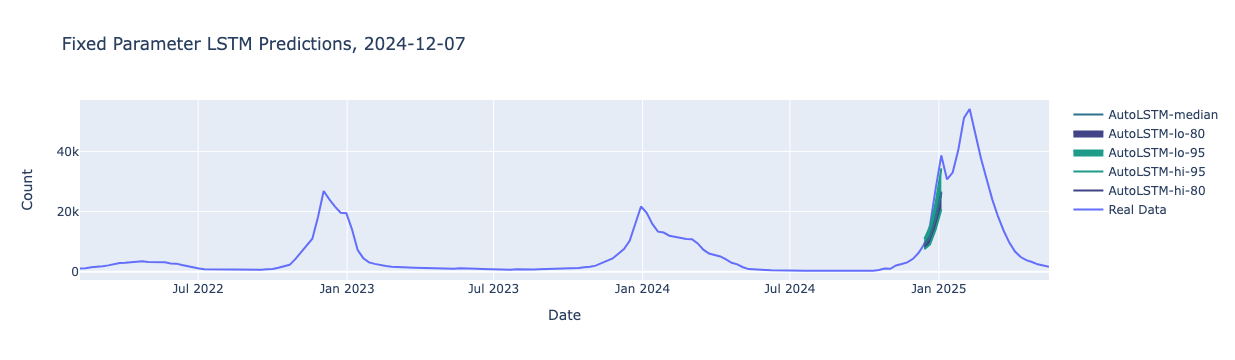

In [20]:
Processor.create_graph()

In [21]:
Processor.color_mapping

{'median': '#2c728e', '80': '#414487', '95': '#1e9c89'}

In [22]:
Processor.calculate_metrics()

In [23]:
Processor.maes

[422.1352844238281,
 1269.1141662597656,
 1710.105224609375,
 689.6666259765625,
 6600.22265625]

In [24]:
Processor.mses

[262824.80317666754,
 2028400.0154623296,
 3176555.0107055604,
 513944.633294642,
 66886398.34222603]

In [25]:
Processor.mapes

[0.48874784669405863,
 0.7233292201600581,
 0.5699475384172624,
 0.15097299028524994,
 0.238809620233889]

In [26]:
Processor.create_display_df()

In [27]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,185.110962
2,2024-10-05,2024-10-12,0.100,247.721680
0,2024-10-05,2024-10-12,0.500,332.723877
3,2024-10-05,2024-10-12,0.900,405.687866
4,2024-10-05,2024-10-12,0.975,629.648071
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,20681.144531
97,2024-12-07,2025-01-04,0.100,26171.826172
95,2024-12-07,2025-01-04,0.500,26160.738281
98,2024-12-07,2025-01-04,0.900,26644.634766


In [28]:
Processor.create_metrics_df()

In [29]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,422.135284,2.628248e+05,0.488748,2.572269
1,2024-10-19,1269.114166,2.028400e+06,0.723329,4.676662
2,2024-11-02,1710.105225,3.176555e+06,0.569948,4.677206
3,2024-11-16,689.666626,5.139446e+05,0.150973,0.097434
4,2024-12-07,6600.222656,6.688640e+07,0.238810,0.518029


In [50]:
Processor2 = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [51]:
Processor2.create_training_dfs(value_col="value")

In [52]:
Processor2.load_fixed_model(path = "AutoLSTM/fixed_models/test_model/")

[rank: 0] Seed set to 8


In [53]:
Processor2.create_fixed_model(h = 4, freq = "W-SAT", model_name = "test_model", level = [80, 95])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [54]:
Processor2.forecasts[0]

,AutoLSTM-median,AutoLSTM-lo-95,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-95
ds,,,,,
2024-10-12,332.723877,185.110962,247.721680,405.687866,629.648071
2024-10-19,311.854858,130.813477,210.293457,380.507874,610.660278
2024-10-26,320.235962,166.575806,217.434937,392.742737,621.452820
2024-11-02,330.091919,185.803711,224.753418,425.494873,675.216919


In [55]:
Processor.forecasts[0]

,AutoLSTM-median,AutoLSTM-lo-95,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-95
ds,,,,,
2024-10-12,332.723877,185.110962,247.721680,405.687866,629.648071
2024-10-19,311.854858,130.813477,210.293457,380.507874,610.660278
2024-10-26,320.235962,166.575806,217.434937,392.742737,621.452820
2024-11-02,330.091919,185.803711,224.753418,425.494873,675.216919


In [56]:
Processor.forecasts[1]

,AutoLSTM-median,AutoLSTM-lo-95,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-95
ds,,,,,
2024-10-26,388.331787,249.953247,304.984375,456.520264,656.164917
2024-11-02,381.376160,215.883057,287.199951,444.589722,649.331482
2024-11-09,396.634094,255.110352,301.714722,465.026367,672.960083
2024-11-16,416.201294,283.547852,315.975464,502.406677,722.187195


In [57]:
Processor2.forecasts[1]

,AutoLSTM-median,AutoLSTM-lo-95,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-95
ds,,,,,
2024-10-26,388.331787,249.953247,304.984375,456.520264,656.164917
2024-11-02,381.376160,215.883057,287.199951,444.589722,649.331482
2024-11-09,396.634094,255.110352,301.714722,465.026367,672.960083
2024-11-16,416.201294,283.547852,315.975464,502.406677,722.187195


In [62]:
class UpdatingModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        
        self.nfs = []
        
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_models(self, h, freq, model_names, level = []):
        if not self.nfs:
            for i in range(len(self.dfs)):
                if not level:
                    nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna")], freq = freq)
                    nf.fit(df = self.dfs[i])
                else:
                    nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level))], freq = freq)
                    nf.fit(df = self.dfs[i])
            
                nf.save(path=f'AutoLSTM/updating_models/{model_names[i]}/')
        
        for i in range(len(self.dfs)):
            y_hat = nf.predict(df = self.dfs[i])
            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

    def load_models(self, paths):
        for i in range(len(paths)):
            nf = NeuralForecast.load(path = path)
            self.nfs.append(nf)
    
        
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Updating Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
        
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
        
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)
            


In [63]:
UpdatingProcessor = UpdatingModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [64]:
UpdatingProcessor.create_training_dfs(value_col = "value")

In [65]:
UpdatingProcessor.create_models(h = 4, freq = "W-SAT", model_names = ["test_1", "test_2", "test_3", "test_4", "test_5"], level = [80, 95])

[I 2025-05-22 17:25:42,530] A new study created in memory with name: no-name-5ce2506e-6b62-4ff9-8f1d-358216613f8c
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 202 K  | train
4 | context_adapter | Linear        | 4.0 K  | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:25:50,469] Trial 0 finished with value: 31.7163143157959 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.0002549805254947939, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 11, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 31.7163143157959.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:25:58,086] Trial 1 finished with value: 123.2090835571289 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0009873698291603809, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 5, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 31.7163143157959.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:26:05,784] Trial 2 finished with value: 80.53797149658203 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0008435914897179603, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 20, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 31.7163143157959.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:26:14,755] Trial 3 finished with value: 10.374438285827637 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0032461517646053266, 'max_steps': 500, 'batch_size': 32, 'random_seed': 17, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 10.374438285827637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:26:25,575] Trial 4 finished with value: 20.58876609802246 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0008603312954676149, 'max_steps': 500, 'batch_size': 32, 'random_seed': 4, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 10.374438285827637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:26:39,958] Trial 5 finished with value: 16.791967391967773 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0005907507587269257, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 13, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 10.374438285827637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:27:01,582] Trial 6 finished with value: 89.72471618652344 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.04922895124859638, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 10, 'input_size': 256, 'inference_input_size': -4}. Best is trial 3 with value: 10.374438285827637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:27:09,208] Trial 7 finished with value: 22.5120906829834 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.04058027350623392, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 13, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 10.374438285827637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:27:18,182] Trial 8 finished with value: 10.230727195739746 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0004045964524733085, 'max_steps': 500, 'batch_size': 32, 'random_seed': 7, 'input_size': 256, 'inference_input_size': -4}. Best is trial 8 with value: 10.230727195739746.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:27:21,844] Trial 9 finished with value: 77.97291564941406 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.007267335632456673, 'max_steps': 500, 'batch_size': 16, 'random_seed': 5, 'input_size': 64, 'inference_input_size': -4}. Best is trial 8 with value: 10.230727195739746.
[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:27:30,966] A new study created in memory with name: no-name-7b599f74-b14d-44d0-8783-3ecb8bc8b0a4
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 71.8 K | train
4 | context_adapter | Linear      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:27:35,014] Trial 0 finished with value: 45.30352783203125 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.011935104875835396, 'max_steps': 500, 'batch_size': 16, 'random_seed': 3, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 45.30352783203125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:27:47,566] Trial 1 finished with value: 543.231689453125 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.05011256181039823, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 7, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 45.30352783203125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:27:52,091] Trial 2 finished with value: 37.39821243286133 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.000881939300023271, 'max_steps': 500, 'batch_size': 32, 'random_seed': 13, 'input_size': -4, 'inference_input_size': -4}. Best is trial 2 with value: 37.39821243286133.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:29:02,197] Trial 9 finished with value: 30.36787986755371 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.000606025891862925, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 20, 'input_size': -4, 'inference_input_size': -4}. Best is trial 8 with value: 28.946392059326172.
[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 31.0 K | train
4 | context_adapter | Linear        | 2.0 K  | train
5 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:29:09,719] A new study created in memory with name: no-name-6c2f7e2e-a800-4a98-aa0d-c00770c13cc7
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 363 K  | train
4 | context_adapter | Linear    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:29:15,106] Trial 0 finished with value: 62.33012008666992 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.06966503952364778, 'max_steps': 500, 'batch_size': 16, 'random_seed': 14, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:29:18,794] Trial 1 finished with value: 155.44525146484375 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.049715969147518524, 'max_steps': 500, 'batch_size': 16, 'random_seed': 17, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:29:26,107] Trial 2 finished with value: 251.65054321289062 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.012355543727761372, 'max_steps': 500, 'batch_size': 16, 'random_seed': 13, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:29:33,804] Trial 3 finished with value: 103.45195007324219 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.036714561569191714, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:29:42,475] Trial 4 finished with value: 233.0289764404297 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.016505490386119467, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 9, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:29:49,726] Trial 5 finished with value: 207.81005859375 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.0001818367277094884, 'max_steps': 500, 'batch_size': 32, 'random_seed': 3, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 62.33012008666992.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:31:00,069] Trial 4 finished with value: 432.0050354003906 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.01680270298693785, 'max_steps': 500, 'batch_size': 32, 'random_seed': 2, 'input_size': -4, 'inference_input_size': -4}. Best is trial 1 with value: 231.9780731201172.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:31:04,381] Trial 5 finished with value: 733.1976928710938 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.03401356304780224, 'max_steps': 500, 'batch_size': 16, 'random_seed': 4, 'input_size': 256, 'inference_input_size': -4}. Best is trial 1 with value: 231.9780731201172.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:31:11,948] Trial 6 finished with value: 148.35482788085938 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.0004037480809041409, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 15, 'input_size': 64, 'inference_input_size': -4}. Best is trial 6 with value: 148.35482788085938.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:31:19,235] Trial 7 finished with value: 265.21044921875 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.000133633476957134, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 9, 'input_size': 64, 'inference_input_size': -4}. Best is trial 6 with value: 148.35482788085938.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:31:36,268] Trial 9 finished with value: 747.2764282226562 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.012178818034013396, 'max_steps': 500, 'batch_size': 16, 'random_seed': 20, 'input_size': -4, 'inference_input_size': -4}. Best is trial 6 with value: 148.35482788085938.
[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 31.0 K | train
4 | context_adapter | Linear        | 10.2 K | train
5 | mlp_dec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:31:43,711] A new study created in memory with name: no-name-a2591726-d54f-4be8-82cd-f92d2c07bcdb
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 363 K  | train
4 | context_adapter | Linear    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-05-22 17:31:49,101] Trial 0 finished with value: 607.0415649414062 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.005654707677978563, 'max_steps': 500, 'batch_size': 32, 'random_seed': 19, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 607.0415649414062.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:33:10,693] Trial 8 finished with value: 299.4823913574219 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0002741078132737356, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 9, 'input_size': 16, 'inference_input_size': -4}. Best is trial 8 with value: 299.4823913574219.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-05-22 17:33:19,198] Trial 9 finished with value: 1187.8638916015625 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0002513656507689763, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 15, 'input_size': 64, 'inference_input_size': -4}. Best is trial 8 with value: 299.4823913574219.
[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 41.2 K | train
4 | context_adapter | Linear        | 2.0 K  | train
5 | mlp_d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
UpdatingProcessor.forecasts[2]

In [ ]:
UpdatingProcessor.create_graph()

In [ ]:
UpdatingProcessor.calculate_metrics()

In [ ]:
UpdatingProcessor.maes

In [ ]:
UpdatingProcessor.create_display_df()

In [ ]:
UpdatingProcessor.display_df

In [ ]:
UpdatingProcessor.create_metrics_df()

In [ ]:
#Retrained
UpdatingProcessor.metrics_df

In [ ]:
#Fixed
Processor.metrics_df

In [ ]:
LSTMmodel = AutoLSTM(h = 4, backend = "optuna")

In [ ]:
LSTMmodel.load(path=f'./AutoLSTM/updating_models/test_model.ckpt')

In [ ]:
nf = NeuralForecast(models = [LSTM(h = 4)], freq = "W-SAT")

In [ ]:
nf.load(path=f'./AutoLSTM/fixed_models/test_model')

In [ ]:
AutoLSTM.save?

In [ ]:
!pwd

In [ ]:
!ls

In [5]:
!ls

 ARIMAPipelines.ipynb   HyperParamOptimization.ipynb
 AutoARIMA	        lightning_logs
 AutoCES	        LSTMHyperParameter.ipynb
 AutoETS	        LSTMPipelines.ipynb
 AutoLSTM	        TimeGPT-ARIMA-LSTM-TFT.ipynb
 AutoLSTM.ipynb        'TimeGPT Notebook.ipynb'
 CESPipelines.ipynb     Untitled.ipynb
 checkpoints	       'Updated Window Experiments.ipynb'
 ETSPipelines.ipynb     WindowExperiments.ipynb


In [6]:
import os

In [7]:
os.getcwd()

'/sfs/gpfs/tardis/home/hmf6av/TimeSeriesComparisons'